## Lab 3
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
try:
    import google.colab
    USE_COLAB = True
except:
    USE_COLAB = False

if USE_COLAB:
    print("Don't forget to avoid disconnections:")
    print("""
    function ClickConnect(){
        console.log("Clicking"); 
        document.querySelector("colab-connect-button").click() 
    }
    setInterval(ClickConnect,60000)
    
    """)

Don't forget to avoid disconnections:

    function ClickConnect(){
        console.log("Clicking"); 
        document.querySelector("colab-connect-button").click() 
    }
    setInterval(ClickConnect,60000)
    
    


In [2]:
WORK_DIR = './'
if USE_COLAB:
    from google.colab import files, drive
    WORK_DIR = '/content/drive/'
    drive.mount(WORK_DIR)
    WORK_DIR += 'My Drive/projects/lab-3-overfit-it/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython import display
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [4]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [5]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2,
                                           pin_memory=True)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2,
                                          pin_memory=True)

In [7]:
len(fmnist_dataset_test)

10000

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


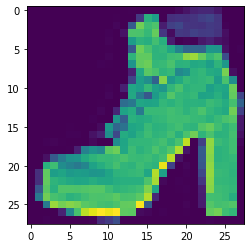

In [8]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    plt.imshow(img[0][0])
    print(label.shape)
    print(label.size(0))
    break

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [0]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, hidden_size=[500, 64]):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape * input_channels, hidden_size[0]),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.Linear(hidden_size[1], num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [0]:
class LearningModel:
    def __init__(self, net, net_name):
        self.net = net
        self.net_name = net_name
        self.optimizer = torch.optim.Adam(net.parameters(), lr=5e-5)
        self.criterion = nn.CrossEntropyLoss()
        self.epoch = 0
        self.metrics = {'accuracy' : {}, 'loss' : {}}
    
    def predict(self, input):
        return self.net.forward(input).argmax(axis=-1)
    
    def get_acc(self, img_batch, label_batch):
        predictions = self.predict(img_batch)
        return (predictions == label_batch).float().mean()

    def get_loss(self, img_batch, label_batch):
        predictions = self.net.forward(img_batch)
        loss = self.criterion(predictions, label_batch)
        return loss

    def evaluate(self, data_loaders):
        with torch.no_grad():
            for name, data_loader in data_loaders.items():
                metrics_sum = {'accuracy':0., 'loss':0.}
                metrics_func = {'accuracy':self.get_acc, 'loss':self.get_loss}
                total_num = 0.
                for img_batch, label_batch in data_loader:
                    batch_size = img_batch.shape[0]
                    img_batch = img_batch.to(device)
                    label_batch = label_batch.to(device)
                    
                    for k in metrics_sum.keys():
                        metrics_sum[k] += metrics_func[k](img_batch, label_batch) * batch_size
                    
                    total_num += batch_size
                
                for k, v in metrics_sum.items():
                    self.metrics[k].setdefault(name, [])
                    self.metrics[k][name].append(v / total_num)


    def fit(self,
            data_loaders,
            n_epoch=20,
           ):
        self.n_epoch = n_epoch

        while self.epoch <= n_epoch:
            display.clear_output(wait=True)
            self.evaluate(data_loaders)
            self.visualize()
            if self.epoch == n_epoch:
                break

            for img_batch, label_batch in data_loaders['train']:
                img_batch = img_batch.to(device)
                label_batch = label_batch.to(device)

                self.optimizer.zero_grad()
                
                loss = self.get_loss(img_batch, label_batch)
            
                # Backward
                loss.backward()
                
                # Update weights
                self.optimizer.step()
            
            self.epoch += 1

        return self
    
    def visualize_metric(self, ax, metric_name):
        ax.set_title(metric_name)
        ax.set_xlabel('Epoch num')
        ax.set_ylabel(metric_name)

        for k, v in self.metrics[metric_name].items():
            ax.plot(v, label=f'On {k} {metric_name}={v[-1]}')
        
        ax.legend(loc='best')

    def visualize(self, independ_plot=False):
        print('Epoch {}/{}'.format(self.epoch, self.n_epoch))

        fig = plt.figure(figsize=(29.7/2, 21.))
        fig.subplots_adjust(top=0.95)
        plt.suptitle(self.net_name, fontsize=20)
        
        loss_ax = fig.add_subplot(2, 1, 1)
        acc_ax = fig.add_subplot(2, 1, 2)

        self.visualize_metric(loss_ax, 'loss')
        self.visualize_metric(acc_ax, 'accuracy')
        
        plt.legend(loc='best')
        plt.show()

In [11]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
           Dropout-3                  [-1, 500]               0
              ReLU-4                  [-1, 500]               0
            Linear-5                   [-1, 64]          32,064
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 10]             650
Total params: 425,214
Trainable params: 425,214
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.62
Estimated Total Size (MB): 1.64
----------------------------------------------------------------


Your experiments come here:

Epoch 1/60


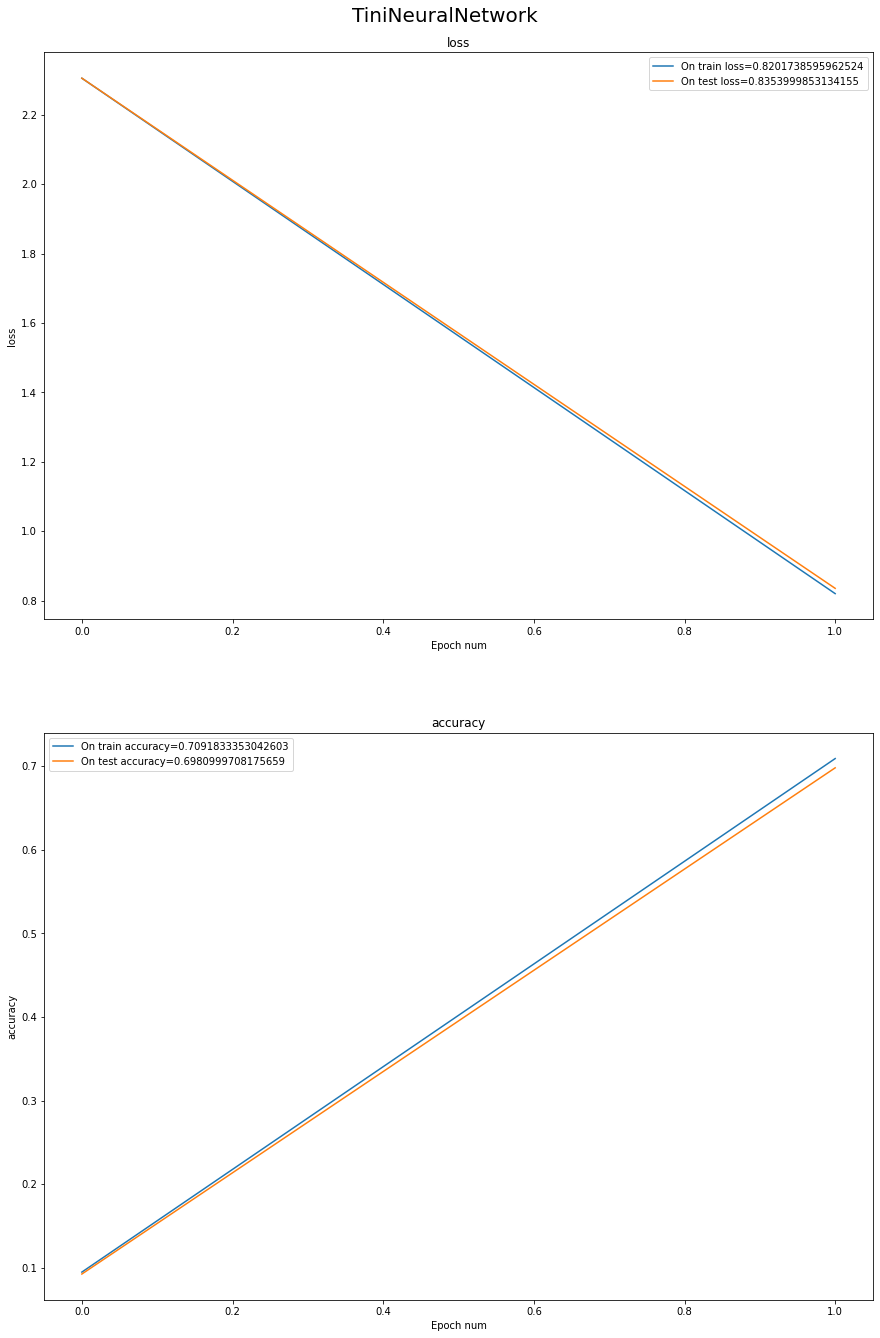

In [0]:
net = TinyNeuralNetwork().to(device)
learn_model = LearningModel(net, 'TiniNeuralNetwork')


learn_model.fit({'train': train_loader, 'test':test_loader}, n_epoch=60)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [0]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape * input_channels, 10000),
            nn.ReLU(),
            nn.Linear(10000, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [0]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                [-1, 10000]       7,850,000
              ReLU-3                [-1, 10000]               0
            Linear-4                   [-1, 10]         100,010
Total params: 7,950,010
Trainable params: 7,950,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 30.33
Estimated Total Size (MB): 30.49
----------------------------------------------------------------


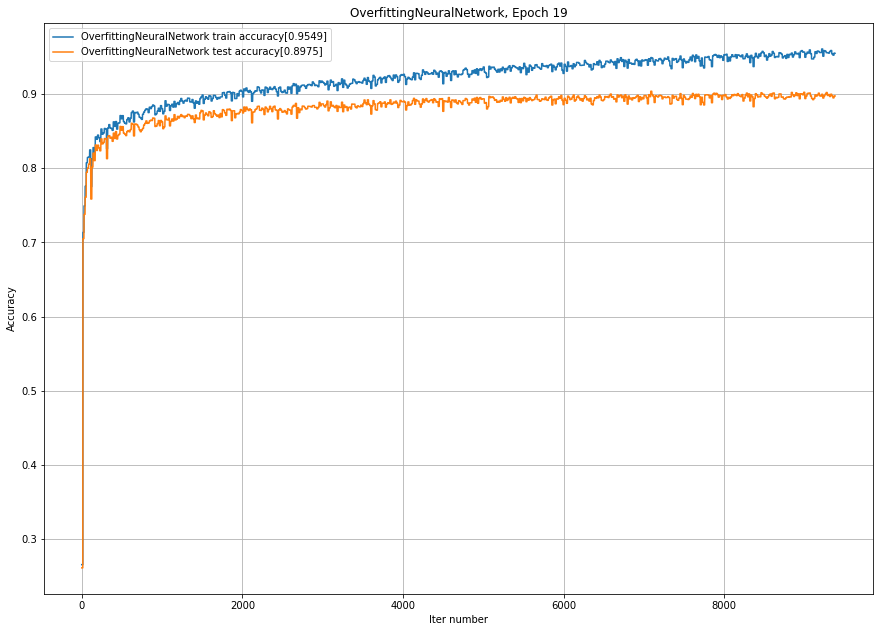

In [0]:
net = OverfittingNeuralNetwork().to(device)
learn_model = LearningModel(net, 'OverfittingNeuralNetwork')


learn_model.fit(train_loader, test_loader)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [0]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape * input_channels, 10000),
            nn.Dropout(),
            nn.BatchNorm1d(10000),
            nn.ReLU(),
            nn.Linear(10000, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [0]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                [-1, 10000]       7,850,000
           Dropout-3                [-1, 10000]               0
       BatchNorm1d-4                [-1, 10000]          20,000
              ReLU-5                [-1, 10000]               0
            Linear-6                   [-1, 10]         100,010
Total params: 7,970,010
Trainable params: 7,970,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.31
Params size (MB): 30.40
Estimated Total Size (MB): 30.72
----------------------------------------------------------------


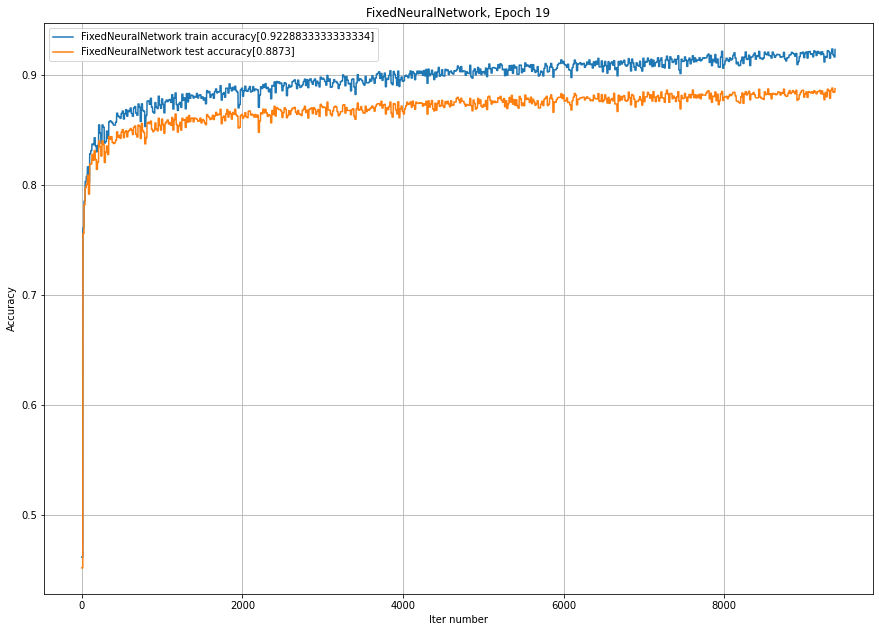

In [0]:
net = FixedNeuralNetwork().to(device)
learn_model = LearningModel(net, 'FixedNeuralNetwork')


learn_model.fit(train_loader, test_loader)

### Conclusions:
Можно заметить, что переобученная модель имеет завышенную точность на трейне. И эта проблема решается, добавлением DropOut и BatchNorm 